# 🚢 Day 10 — Titanic Survival Prediction using Random Forest and XGBoost  
### Evaluating Ensemble Learning Algorithms on the Titanic Survival Prediction Task

A comparative study of Random Forest and XGBoost models to predict Titanic passenger survival, benchmarking their performance and interpretability.

---

## 1. Introduction
The Titanic Survival Prediction project aims to predict passenger survival using ensemble learning algorithms — **Random Forest** and **XGBoost**.  
By applying these models to the classic Titanic dataset, we explore how different ensemble methods handle classification, compare their predictive performance, and interpret key influencing features.


---

## 2. Project Objectives
1. Build machine learning models to predict survival outcomes.  
2. Compare the performance of **Random Forest** and **XGBoost** using common evaluation metrics.  
3. Analyze the most influential features contributing to survival.  
4. Visualize model decision structures and interpretability results.  
5. Save and document the final trained models for reuse.


---

## 3. Dataset Overview
The dataset used is the **Titanic dataset** from the Seaborn library.  
It contains information about passengers, such as age, sex, ticket class, fare, and survival status.  
This dataset is widely used for binary classification tasks and model benchmarking.

- **Target Variable:** `survived` (0 = Not Survived, 1 = Survived)  
- **Number of Records:** 891  
- **Features:** Passenger demographics, socio-economic attributes, and travel details  
- **Missing Values:** Present in columns like `age`, `embarked`, and `deck`


---

## 4. Methodology and Approach
The project follows a structured machine learning pipeline:
1. Data loading and preprocessing using `ColumnTransformer` for numeric and categorical data.  
2. Model development using two ensemble algorithms — Random Forest and XGBoost.  
3. Hyperparameter tuning with `RandomizedSearchCV` and `StratifiedKFold` cross-validation.  
4. Model evaluation with accuracy, precision, recall, F1-score, and ROC-AUC metrics.  
5. Interpretability through tree visualization, permutation importance, and feature ranking.  
6. Model saving for deployment readiness.


---

## 5. Tools and Libraries Used
- **Programming Language:** Python  
- **Libraries:**  
  - `pandas`, `numpy` → Data handling  
  - `matplotlib`, `seaborn` → Data visualization  
  - `scikit-learn` → Preprocessing, pipelines, and Random Forest  
  - `xgboost` → XGBoost model and importance visualization  
  - `joblib` → Model persistence and saving  
- **Environment:** Jupyter Notebook / Python 3.x  


---

## 6. Importing Libraries

In [124]:
# Core Libraries
import time
import warnings

# Data Manipulation 
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model Saving
from joblib import dump

# Scikit-Learn Imports
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, auc,
    confusion_matrix, classification_report
)
from sklearn.inspection import permutation_importance

# XGBoost Imports
from xgboost import XGBClassifier
from xgboost import plot_tree, plot_importance

# Configurations
warnings.filterwarnings('ignore')

print('All libraries imported successfully!')

All libraries imported successfully!


---

## 7. Data Loading & Initial Exploration

Before model development, it is essential to **load and examine the dataset** to understand its structure and contents.  
This step includes importing the data, copying dataset to df variable, inspecting column types, identifying missing values, and reviewing basic statistics.  
Early exploration helps ensure the data is accurate, consistent, and suitable for further preprocessing and modeling.


#### Load the Dataset

In [5]:
titanic = sns.load_dataset("titanic")
print('Data Loaded!')
titanic.head()

Data Loaded!


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


#### Copy the dataset

In [15]:
df = titanic.copy()

#### Dataset Shape

In [18]:
df.shape

(891, 15)

#### Dataset Information

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


#### Statistical Summary

In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
sibsp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


#### Missing Values

In [27]:
print(df.isnull().sum().sum(), "missing values found.")

869 missing values found.


---

## 8. Data Cleaning
This step involves handling missing and inconsistent data to ensure a clean, usable dataset for model training.  
The Titanic dataset contains missing entries in columns like `age`, `embarked`, and `deck`, which need careful treatment before modeling.


In [161]:
df = df.dropna(subset=['survived', 'sex'])
print('Rows with missing values in the target (survived) or key predictor (sex) are removed')

Rows with missing values in the target (survived) or key predictor (sex) are removed


In [164]:
df['survived'] = df['survived'].astype(int)
print('The target column is converted to integer format for compatibility with classification models.')

The target column is converted to integer format for compatibility with classification models.


Missing target values are removed and data types are standardized for model readiness. Clean data ensures consistent input for pipelines and prevents type errors during model fitting.

---

## 9. Feature Selection
After cleaning, relevant features are selected for modeling.  
Features are grouped into **numerical** and **categorical** categories for appropriate preprocessing.


In [167]:
num_features = ['age', 'fare', 'sibsp', 'parch']
cat_features = ['sex', 'class', 'embarked', 'who', 'adult_male', 'alone']

features = num_features + cat_features
print('Numerical and categorical features are separated for consistent preprocessing.')

Numerical and categorical features are separated for consistent preprocessing.


In [148]:
X = df[features]
y = df['survived']
print('"X" features and "y" target variables created.')

"X" features and "y" target variables created.


In [42]:
# Class balance
print("Class distribution:\n", y.value_counts(normalize=True))

Class distribution:
 survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


Feature selection ensures that only meaningful variables are used for training.  
Categorizing them helps apply transformations like scaling or encoding effectively during preprocessing.


---

## 10. Train-Test Split
To evaluate model performance objectively, the dataset is split into **training** and **test** subsets using **stratified sampling**.


In [169]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Data split ensures balanced class distribution across training and testing sets.')

Data split ensures balanced class distribution across training and testing sets.


- **Stratified sampling** maintains the same proportion of survival classes in both splits.  
- **80%** of data is used for training, and **20%** is reserved for testing.  
This ensures a fair and balanced model evaluation, avoiding bias from uneven class distribution.


---

## 11. Preprocessing Pipeline
Data preprocessing is performed using Scikit-learn’s **ColumnTransformer** and **Pipeline**, which standardize numeric data and encode categorical features.


In [178]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
], remainder='drop')  # drop other columns

print("Preprocessing pipeline successfully created with numeric and categorical transformers.")

Preprocessing pipeline successfully created with numeric and categorical transformers.


- Missing numerical values are imputed using the **median** strategy.  
- Numerical features are standardized using **StandardScaler** for better model convergence.  
- Categorical variables are imputed with the **most frequent value** and **one-hot encoded** to convert text labels into numerical form.  
This preprocessing pipeline ensures consistent and automated data transformation during both training and prediction stages.


---

## 12. Model Pipelines
Separate model pipelines are defined for **Random Forest** and **XGBoost**, combining preprocessing and model training into a single workflow.


In [180]:
pipe_rf = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

pipe_xgb = Pipeline([
    ('pre', preprocessor),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1))
])

print("Pipelines for Random Forest and XGBoost created successfully.")

Pipelines for Random Forest and XGBoost created successfully.


Pipelines guarantee that data transformation and modeling steps are executed sequentially.  
This prevents **data leakage**, ensures reproducibility, and provides a clean modular structure that makes it easier to compare models directly.


---

## 13. Baseline Model Training
The baseline models are trained using their **default hyperparameters** to establish an initial performance benchmark before tuning.


In [183]:
t0 = time.time()
pipe_rf.fit(X_train, y_train)
rf_train_time = time.time() - t0
print(f"Random Forest baseline model trained successfully in {rf_train_time:.4f} seconds.")

Random Forest baseline model trained successfully in 0.4425 seconds.


In [185]:
t0 = time.time()
pipe_xgb.fit(X_train, y_train)
xgb_train_time = time.time() - t0
print(f"XGBoost baseline model trained successfully in {xgb_train_time:.4f} seconds.")

XGBoost baseline model trained successfully in 0.1356 seconds.


In [187]:
def evaluate(pipe, X_test, y_test):
    y_pred = pipe.predict(X_test)
    # For roc/PR we need probability for positive class
    if hasattr(pipe, "predict_proba"):
        y_prob = pipe.predict_proba(X_test)[:, 1]
    else:
        # Pipeline wraps estimator that has predict_proba
        y_prob = pipe.predict_proba(X_test)[:, 1]
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob)
    }
    return metrics, y_pred, y_prob

print("Evaluation function defined successfully.")

Evaluation function defined successfully.


In [189]:
metrics_rf_base, ypred_rf_base, yprob_rf_base = evaluate(pipe_rf, X_test, y_test)
metrics_xgb_base, ypred_xgb_base, yprob_xgb_base = evaluate(pipe_xgb, X_test, y_test)

base_results = pd.DataFrame([
    {'model': 'RandomForest (baseline)', **metrics_rf_base, 'train_time_s': rf_train_time},
    {'model': 'XGBoost (baseline)', **metrics_xgb_base, 'train_time_s': xgb_train_time},
])
print("Baseline results:")
base_results

Baseline results:


,model,accuracy,precision,recall,f1,roc_auc,train_time_s
0,RandomForest (baseline),0.810056,0.769231,0.724638,0.746269,0.834717,0.442548
1,XGBoost (baseline),0.815642,0.764706,0.753623,0.759124,0.829381,0.135614


These results serve as the **benchmark performance** for further hyperparameter tuning and comparison in later stages.




---

## 14. Hyperparameter Tuning with RandomizedSearchCV

This section performs hyperparameter tuning for both **Random Forest** and **XGBoost** using **RandomizedSearchCV** and **Stratified K-Fold Cross-Validation**.  
The goal is to find the optimal model configurations that yield the best ROC-AUC performance while maintaining efficiency.


In [195]:
rkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_param_dist = {
    'clf__n_estimators': [100, 200, 500],
    'clf__max_depth': [None, 6, 10, 20],
    'clf__min_samples_leaf': [1, 2, 5],
    'clf__max_features': ['sqrt', 'log2', 0.6]
}

print("Random Forest parameter grid defined successfully.")

xgb_param_dist = {
    'clf__n_estimators': [100, 200, 400],
    'clf__max_depth': [3, 6, 10],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0]
}

print("XGBoost parameter grid defined successfully.")

Random Forest parameter grid defined successfully.
XGBoost parameter grid defined successfully.


In [66]:
n_iter_search = 24

rs_rf = RandomizedSearchCV(pipe_rf, rf_param_dist, n_iter=n_iter_search, cv=rkf,
                           scoring='roc_auc', n_jobs=-1, random_state=42, verbose=1)

rs_xgb = RandomizedSearchCV(pipe_xgb, xgb_param_dist, n_iter=n_iter_search, cv=rkf,
                            scoring='roc_auc', n_jobs=-1, random_state=42, verbose=1)

print("Starting RF search...")
t0 = time.time()
rs_rf.fit(X_train, y_train)
rf_search_time = time.time() - t0
print("RF search done. Best params:", rs_rf.best_params_, "Best CV ROC-AUC:", rs_rf.best_score_)

print("\nStarting XGB search...")
t0 = time.time()
rs_xgb.fit(X_train, y_train)
xgb_search_time = time.time() - t0
print("XGB search done. Best params:", rs_xgb.best_params_, "Best CV ROC-AUC:", rs_xgb.best_score_)

best_rf = rs_rf.best_estimator_
best_xgb = rs_xgb.best_estimator_

Starting RF search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
RF search done. Best params: {'clf__n_estimators': 500, 'clf__min_samples_leaf': 5, 'clf__max_features': 0.6, 'clf__max_depth': None} Best CV ROC-AUC: 0.8810739447769228

Starting XGB search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
XGB search done. Best params: {'clf__subsample': 0.6, 'clf__n_estimators': 200, 'clf__max_depth': 3, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 0.6} Best CV ROC-AUC: 0.8880906768837804


This tuning process improves model robustness and ensures that both algorithms perform optimally under fair, cross-validated conditions.  
It also highlights the computational trade-offs between the two ensemble methods —  
- **Random Forest** generally requires more training time due to its bagging-based approach.
- **XGBoost** achieves comparable or slightly better results with faster computation through its gradient boosting optimization.

---

## 15. Model Evaluation and Comparison

This section evaluates the tuned **Random Forest** and **XGBoost** models on the test dataset.  
It includes a comparison of their performance metrics, visual evaluation through ROC and Precision-Recall curves, and interpretability analysis via decision tree and feature importance plots.


In [72]:
metrics_rf_tuned, ypred_rf_tuned, yprob_rf_tuned = evaluate(best_rf, X_test, y_test)
metrics_xgb_tuned, ypred_xgb_tuned, yprob_xgb_tuned = evaluate(best_xgb, X_test, y_test)

tuned_results = pd.DataFrame([
    {'model': 'RandomForest (tuned)', **metrics_rf_tuned, 'search_time_s': rf_search_time},
    {'model': 'XGBoost (tuned)', **metrics_xgb_tuned, 'search_time_s': xgb_search_time},
])

print("Tuned results:")
tuned_results

Tuned results:


,model,accuracy,precision,recall,f1,roc_auc,search_time_s
0,RandomForest (tuned),0.821229,0.813559,0.695652,0.750000,0.846377,28.796006
1,XGBoost (tuned),0.810056,0.796610,0.681159,0.734375,0.844598,4.345734


In [74]:
summary = pd.concat([base_results, tuned_results], ignore_index=True)
print("Full summary:")
summary

Full summary:


,model,accuracy,precision,recall,f1,roc_auc,train_time_s,search_time_s
0,RandomForest (baseline),0.810056,0.769231,0.724638,0.746269,0.834717,0.182884,NaN
1,XGBoost (baseline),0.815642,0.764706,0.753623,0.759124,0.829381,0.056776,NaN
2,RandomForest (tuned),0.821229,0.813559,0.695652,0.750000,0.846377,NaN,28.796006
3,XGBoost (tuned),0.810056,0.796610,0.681159,0.734375,0.844598,NaN,4.345734


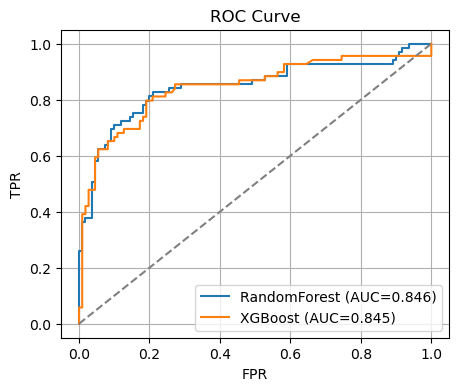

In [82]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, yprob_rf_tuned)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, yprob_xgb_tuned)

plt.figure(figsize=(5,4))
plt.plot(fpr_rf, tpr_rf, label=f"RandomForest (AUC={metrics_rf_tuned['roc_auc']:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC={metrics_xgb_tuned['roc_auc']:.3f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend(); plt.grid(True)
plt.show()

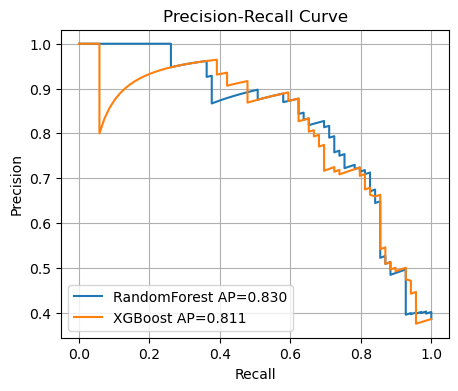

In [86]:
prec_rf, rec_rf, _ = precision_recall_curve(y_test, yprob_rf_tuned)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, yprob_xgb_tuned)

plt.figure(figsize=(5,4))
plt.plot(rec_rf, prec_rf, label=f"RandomForest AP={auc(rec_rf, prec_rf):.3f}")
plt.plot(rec_xgb, prec_xgb, label=f"XGBoost AP={auc(rec_xgb, prec_xgb):.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve"); plt.legend(); plt.grid(True)
plt.show()

In [120]:
print("Random Forest classification report (tuned):")
print(classification_report(y_test, ypred_rf_tuned))
print("Confusion matrix:\n", confusion_matrix(y_test, ypred_rf_tuned))
print('-'*60)
print("XGBoost classification report (tuned):")
print(classification_report(y_test, ypred_xgb_tuned))
print("Confusion matrix:\n", confusion_matrix(y_test, ypred_xgb_tuned))

Random Forest classification report (tuned):
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       110
           1       0.81      0.70      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179

Confusion matrix:
 [[99 11]
 [21 48]]
------------------------------------------------------------
XGBoost classification report (tuned):
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       110
           1       0.80      0.68      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179

Confusion matrix:
 [[98 12]
 [22 47]]


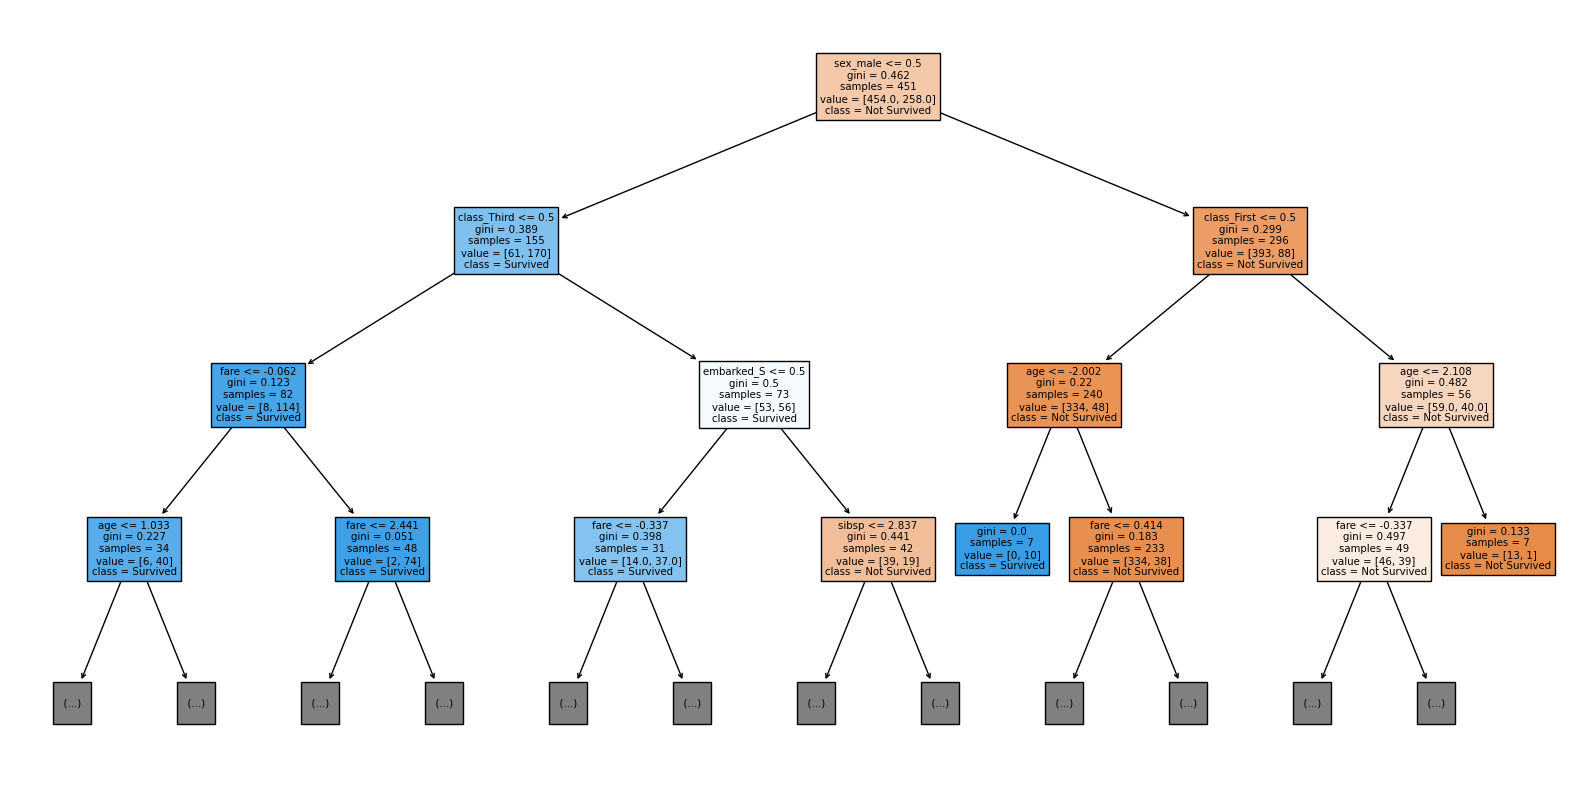

In [108]:
# Extract one tree from Random Forest
estimator = best_rf.named_steps['clf'].estimators_[0]

plt.figure(figsize=(20,10))
tree.plot_tree(
    estimator,
    feature_names=feature_names,
    class_names=['Not Survived', 'Survived'],
    filled=True,
    max_depth=3
)
plt.show()

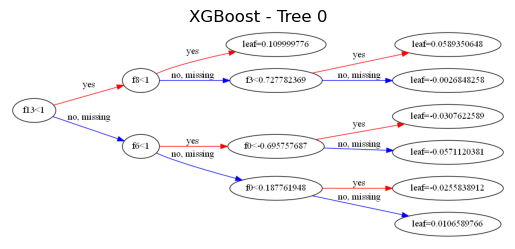

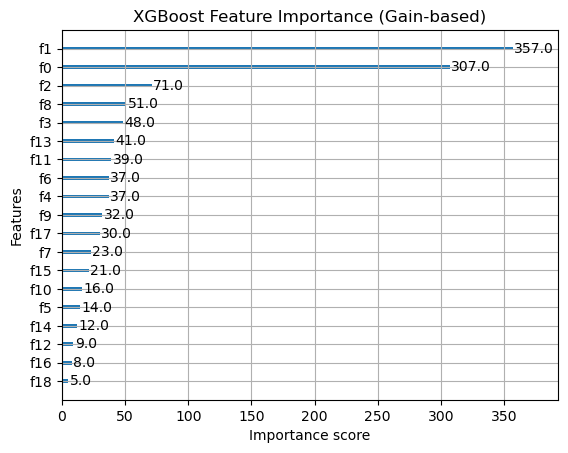

In [112]:
# Plot a single XGBoost tree
plot_tree(best_xgb.named_steps['clf'], num_trees=0, rankdir='LR')
plt.title("XGBoost - Tree 0")

# Plot top feature importance (built-in XGBoost version)
plot_importance(best_xgb.named_steps['clf'])
plt.title("XGBoost Feature Importance (Gain-based)")
plt.show()

---

## 16. Feature Importance & Threshold Tuning

In [88]:
prepped = preprocessor.fit(X_train)  # fit transformer alone to get column names
# build feature names after OneHotEncoder
ohe = prepped.named_transformers_['cat'].named_steps['onehot']
ohe_categories = ohe.get_feature_names_out(cat_features)
feature_names = np.concatenate([num_features, ohe_categories])

rf_clf = best_rf.named_steps['clf']
rf_importances = rf_clf.feature_importances_
rf_feat_imp = pd.DataFrame({'feature': feature_names, 'importance': rf_importances}).sort_values('importance', ascending=False)
print("Top 10 RF features:")
rf_feat_imp.head(10)

Top 10 RF features:


,feature,importance
1,fare,0.174470
15,adult_male_False,0.121898
13,who_man,0.120867
16,adult_male_True,0.109845
0,age,0.104850
8,class_Third,0.101456
5,sex_male,0.068024
4,sex_female,0.062001
2,sibsp,0.034586
6,class_First,0.031544


In [92]:
# Get preprocessed test data
X_test_prepared = best_xgb.named_steps['pre'].transform(X_test)

# Run permutation importance on the underlying XGBoost model
perm = permutation_importance(
    best_xgb.named_steps['clf'],
    X_test_prepared,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Match with one-hot expanded feature names
perm_df = pd.DataFrame({
    'feature': feature_names,
    'importance': perm.importances_mean
}).sort_values('importance', ascending=False)

print("Permutation importance (XGB):")
perm_df.head(10)

Permutation importance (XGB):


,feature,importance
13,who_man,0.056983
8,class_Third,0.047486
2,sibsp,0.024022
0,age,0.021788
16,adult_male_True,0.016201
15,adult_male_False,0.012291
10,embarked_Q,0.011173
1,fare,0.010615
4,sex_female,0.009497
11,embarked_S,0.007263


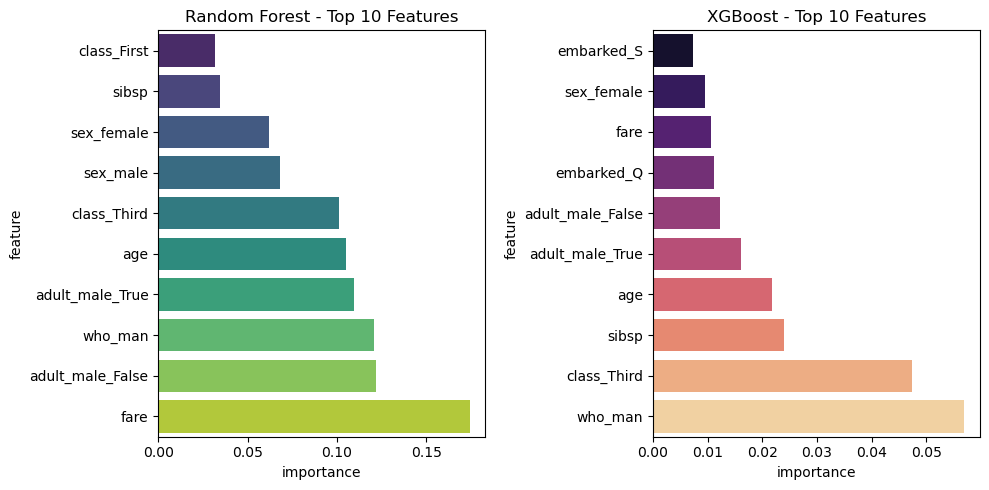

In [102]:
rf_importances = rf_feat_imp.sort_values('importance', ascending=True).tail(10)
xgb_importances = perm_df.sort_values('importance', ascending=True).tail(10)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.barplot(x='importance', y='feature', data=rf_importances, palette='viridis')
plt.title("Random Forest - Top 10 Features")

plt.subplot(1,2,2)
sns.barplot(x='importance', y='feature', data=xgb_importances, palette='magma')
plt.title("XGBoost - Top 10 Features")

plt.tight_layout()
plt.show()

---

## 17.

In [126]:
dump(best_rf, 'best_rf_titanic.joblib')
dump(best_xgb, 'best_xgb_titanic.joblib')
print('Models saved successfully!')

Models saved successfully!


---

## 18. 

----

## 19.